训练集数据量: 1361
测试集数据量: 100


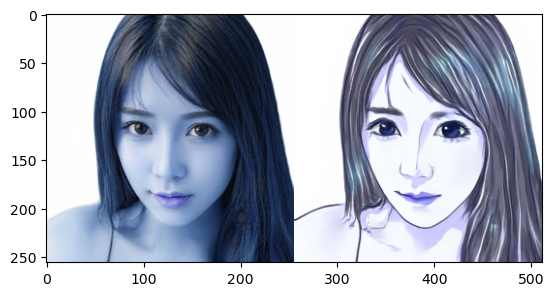

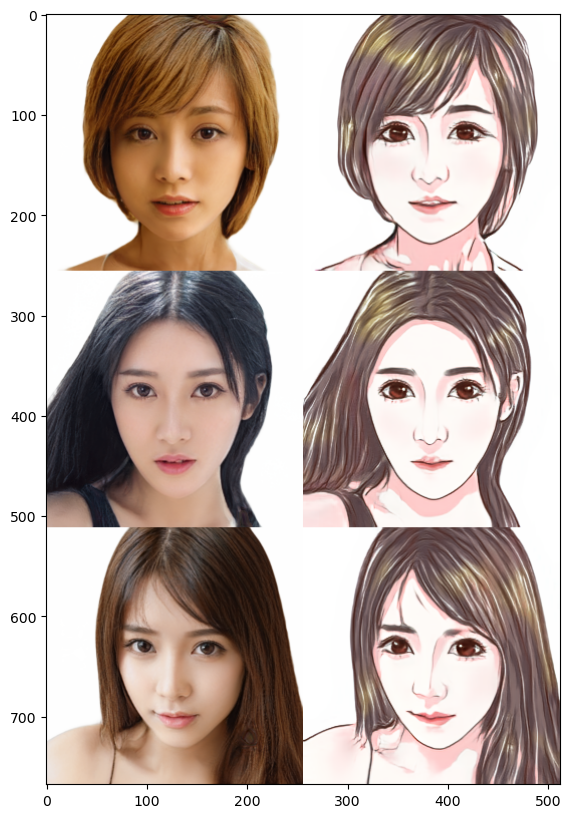

In [57]:
import paddle
import paddle.nn as nn
from paddle.io import Dataset, DataLoader

import os
import cv2
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline


# 训练数据统计
train_names = os.listdir('../data/cartoon_A2B/train')
print(f'训练集数据量: {len(train_names)}')

# 测试数据统计
test_names = os.listdir('../data/cartoon_A2B/test')
print(f'测试集数据量: {len(test_names)}')

# 训练数据可视化
imgs = []
for img_name in np.random.choice(train_names, 3, replace=False):
    imgs.append(cv2.imread('../data/cartoon_A2B/train/'+img_name))

plt.imshow(imgs[0])
plt.imshow(imgs[1])
plt.imshow(imgs[2])
img_show = np.vstack(imgs)[:,:,::-1]
plt.figure(figsize=(10, 10))
plt.imshow(img_show)
plt.show()

- 将列表 imgs 中的三张图像沿着垂直方向进行叠加，并且通过切片操作将它们的通道顺序从 BGR（蓝、绿、红） 转换为 RGB（红、绿、蓝)

## HWC格式转换为CHW格式:
在计算机视觉中，通常将图像表示为三维矩阵。如果图像的大小为 $h\times w$，并且具有 $c$ 个颜色通道，则其形状为 $(h,w,c)$。这种格式通常被称为 HWC 格式，其中 H 代表 height、W 代表 width，而 C 代表 channels，通常是 RGB、BGR 或灰度等颜色通道。

而在深度学习中，常使用的是 CHW 格式，即将通道维度放到矩阵的最前面，即 $(c,h,w)$。在上述代码中，通过 img_A2B.transpose(2, 0, 1) 将 HWC 格式的图像数据转换为 CHW 格式的图像数据。这样转换的目的是为了适应 PyTorch 等深度学习框架中的输入数据格式要求。


In [58]:

class PairedData(paddle.io.Dataset):
    def __init__(self, phase):
        super(PairedData, self).__init__()
        self.img_path_list = self.load_A2B_data(phase)    # 获取数据列表
        self.num_samples = len(self.img_path_list)        # 数据量

    def __getitem__(self, idx):
        img_A2B = cv2.imread(self.img_path_list[idx])     # 读取数据
        img_A2B = img_A2B.astype('float32') / 127.5 - 1.  # 归一化、然后将图像像素值转换为float32类型并归一化到-1到1之间。
        img_A2B = img_A2B.transpose(2, 0, 1)              # HWC -> CHW
        img_A = img_A2B[..., 256:]                        # 卡通图（原图）
        img_B = img_A2B[..., :256]                        # 真人图（标签）
        return img_A, img_B

    def __len__(self):
        return self.num_samples

    @staticmethod
    def load_A2B_data(phase):
        assert phase in ['train', 'test'], "phase should be set within ['train', 'test']"
        # 读取数据集，数据中每张图像包含照片和对应的卡通画。
        data_path = '../data/cartoon_A2B/'+phase
        return [os.path.join(data_path, x) for x in os.listdir(data_path)]


paired_dataset_train = PairedData('train')
paired_dataset_test = PairedData('test')

# 定义生成器

In [59]:
class UnetGenerator(nn.Layer):
    def __init__(self, input_nc=3, output_nc=3, ngf=64):
        super(UnetGenerator, self).__init__()

        self.down1 = nn.Conv2D(input_nc, ngf, kernel_size=4, stride=2, padding=1)
        self.down2 = Downsample(ngf, ngf*2)
        self.down3 = Downsample(ngf*2, ngf*4)
        self.down4 = Downsample(ngf*4, ngf*8)
        self.down5 = Downsample(ngf*8, ngf*8)
        self.down6 = Downsample(ngf*8, ngf*8)
        self.down7 = Downsample(ngf*8, ngf*8)

        self.center = Downsample(ngf*8, ngf*8)

        self.up7 = Upsample(ngf*8, ngf*8, use_dropout=True)
        self.up6 = Upsample(ngf*8*2, ngf*8, use_dropout=True)
        self.up5 = Upsample(ngf*8*2, ngf*8, use_dropout=True)
        self.up4 = Upsample(ngf*8*2, ngf*8)
        self.up3 = Upsample(ngf*8*2, ngf*4)
        self.up2 = Upsample(ngf*4*2, ngf*2)
        self.up1 = Upsample(ngf*2*2, ngf)

        self.output_block = nn.Sequential(
            nn.ReLU(),
            nn.Conv2DTranspose(ngf*2, output_nc, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
        )

    def forward(self, x):
        d1 = self.down1(x)
        d2 = self.down2(d1)
        d3 = self.down3(d2)
        d4 = self.down4(d3)
        d5 = self.down5(d4)
        d6 = self.down6(d5)
        d7 = self.down7(d6)

        c = self.center(d7)

        x = self.up7(c, d7)
        x = self.up6(x, d6)
        x = self.up5(x, d5)
        x = self.up4(x, d4)
        x = self.up3(x, d3)
        x = self.up2(x, d2)
        x = self.up1(x, d1)

        x = self.output_block(x)
        return x


class Downsample(nn.Layer):
    # LeakyReLU => conv => batch norm
    def __init__(self, in_dim, out_dim, kernel_size=4, stride=2, padding=1):
        super(Downsample, self).__init__()

        self.layers = nn.Sequential(
            nn.LeakyReLU(0.2),
            nn.Conv2D(in_dim, out_dim, kernel_size, stride, padding, bias_attr=False),
            nn.BatchNorm2D(out_dim)
        )

    def forward(self, x):
        x = self.layers(x)
        return x


class Upsample(nn.Layer):
    # ReLU => deconv => batch norm => dropout
    def __init__(self, in_dim, out_dim, kernel_size=4, stride=2, padding=1, use_dropout=False):
        super(Upsample, self).__init__()

        sequence = [
            nn.ReLU(),
            nn.Conv2DTranspose(in_dim, out_dim, kernel_size, stride, padding, bias_attr=False),
            nn.BatchNorm2D(out_dim)
        ]

        if use_dropout:
            sequence.append(nn.Dropout(p=0.5))

        self.layers = nn.Sequential(*sequence)

    def forward(self, x, skip):
        x = self.layers(x)
        x = paddle.concat([x, skip], axis=1)
        return x

# 定义鉴别器

In [60]:
class NLayerDiscriminator(nn.Layer):
    def __init__(self, input_nc=6, ndf=64):
        super(NLayerDiscriminator, self).__init__()

        self.layers = nn.Sequential(
            nn.Conv2D(input_nc, ndf, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2),

            ConvBlock(ndf, ndf*2),
            ConvBlock(ndf*2, ndf*4),
            ConvBlock(ndf*4, ndf*8, stride=1),

            nn.Conv2D(ndf*8, 1, kernel_size=4, stride=1, padding=1),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.layers(input)


class ConvBlock(nn.Layer):
    # conv => batch norm => LeakyReLU
    def __init__(self, in_dim, out_dim, kernel_size=4, stride=2, padding=1):
        super(ConvBlock, self).__init__()

        self.layers = nn.Sequential(
            nn.Conv2D(in_dim, out_dim, kernel_size, stride, padding, bias_attr=False),
            nn.BatchNorm2D(out_dim),
            nn.LeakyReLU(0.2)
        )

    def forward(self, x):
        x = self.layers(x)
        return x

In [61]:
generator = UnetGenerator()
discriminator = NLayerDiscriminator()

out = generator(paddle.ones([1, 3, 256, 256]))
print('生成器输出尺寸：', out.shape)

out = discriminator(paddle.ones([1, 6, 256, 256]))
print('鉴别器输出尺寸：', out.shape)


# 超参数
LR = 1e-4
BATCH_SIZE = 8
EPOCHS = 100

# 优化器
optimizerG = paddle.optimizer.Adam(
    learning_rate=LR,
    parameters=generator.parameters(),
    beta1=0.5,
    beta2=0.999)

optimizerD = paddle.optimizer.Adam(
    learning_rate=LR,
    parameters=discriminator.parameters(),
    beta1=0.5,
    beta2=0.999)

# 损失函数
bce_loss = nn.BCELoss()
l1_loss = nn.L1Loss()

# dataloader
data_loader_train = DataLoader(
    paired_dataset_train,
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=True
    )

data_loader_test = DataLoader(
    paired_dataset_test,
    batch_size=BATCH_SIZE
    )

生成器输出尺寸： [1, 3, 256, 256]
鉴别器输出尺寸： [1, 1, 30, 30]


In [62]:
results_save_path = 'work/results'
os.makedirs(results_save_path, exist_ok=True)  # 保存每个epoch的测试结果

weights_save_path = 'work/weights'
os.makedirs(weights_save_path, exist_ok=True)  # 保存模型

for epoch in range(EPOCHS):
    for data in tqdm(data_loader_train):
        real_A, real_B = data

        optimizerD.clear_grad()
        # D(real)
        real_AB = paddle.concat((real_A, real_B), 1)
        d_real_predict = discriminator(real_AB)
        d_real_loss = bce_loss(d_real_predict, paddle.ones_like(d_real_predict))

        # D(fake)
        fake_B = generator(real_A).detach()
        fake_AB = paddle.concat((real_A, fake_B), 1)
        d_fake_predict = discriminator(fake_AB)
        d_fake_loss = bce_loss(d_fake_predict, paddle.zeros_like(d_fake_predict))

        # train D
        d_loss = (d_real_loss + d_fake_loss) / 2.
        d_loss.backward()
        optimizerD.step()

        optimizerG.clear_grad()
        # D(fake)
        fake_B = generator(real_A)
        fake_AB = paddle.concat((real_A, fake_B), 1)
        g_fake_predict = discriminator(fake_AB)
        g_bce_loss = bce_loss(g_fake_predict, paddle.ones_like(g_fake_predict))
        g_l1_loss = l1_loss(fake_B, real_B) * 100.
        g_loss = g_bce_loss + g_l1_loss

        # train G
        g_loss.backward()
        optimizerG.step()

    print(f'Epoch [{epoch+1}/{EPOCHS}] Loss D: {d_loss.numpy()}, Loss G: {g_loss.numpy()}')

    if (epoch+1) % 10 == 0:
        paddle.save(generator.state_dict(), os.path.join(weights_save_path, 'epoch'+str(epoch+1).zfill(3)+'.pdparams'))

        # test
        generator.eval()
        with paddle.no_grad():
            for data in data_loader_test:
                real_A, real_B = data
                break

            fake_B = generator(real_A)
            result = paddle.concat([real_A[:3], real_B[:3], fake_B[:3]], 3)

            result = result.detach().numpy().transpose(0, 2, 3, 1)
            result = np.vstack(result)
            result = (result * 127.5 + 127.5).astype(np.uint8)

        cv2.imwrite(os.path.join(results_save_path, 'epoch'+str(epoch+1).zfill(3)+'.png'), result)

        generator.train()

100%|██████████| 170/170 [01:08<00:00,  2.49it/s]


Epoch [1/100] Loss D: [0.5703423], Loss G: [14.218366]


100%|██████████| 170/170 [00:39<00:00,  4.26it/s]


Epoch [2/100] Loss D: [0.721017], Loss G: [12.29348]


100%|██████████| 170/170 [00:40<00:00,  4.22it/s]


Epoch [3/100] Loss D: [0.5145049], Loss G: [10.564326]


100%|██████████| 170/170 [00:39<00:00,  4.31it/s]


Epoch [4/100] Loss D: [0.55557036], Loss G: [10.095855]


100%|██████████| 170/170 [00:39<00:00,  4.33it/s]


Epoch [5/100] Loss D: [0.5333254], Loss G: [9.771712]


100%|██████████| 170/170 [00:38<00:00,  4.39it/s]


Epoch [6/100] Loss D: [0.56754357], Loss G: [9.742109]


100%|██████████| 170/170 [00:39<00:00,  4.30it/s]


Epoch [7/100] Loss D: [0.6804186], Loss G: [9.661558]


100%|██████████| 170/170 [00:40<00:00,  4.24it/s]


Epoch [8/100] Loss D: [0.5609507], Loss G: [9.626371]


100%|██████████| 170/170 [00:38<00:00,  4.36it/s]


Epoch [9/100] Loss D: [0.76679456], Loss G: [8.940016]


100%|██████████| 170/170 [00:38<00:00,  4.40it/s]


Epoch [10/100] Loss D: [0.66831213], Loss G: [9.002964]


100%|██████████| 170/170 [00:39<00:00,  4.34it/s]


Epoch [11/100] Loss D: [0.5766135], Loss G: [9.546847]


100%|██████████| 170/170 [00:38<00:00,  4.39it/s]


Epoch [12/100] Loss D: [0.72706246], Loss G: [8.163246]


100%|██████████| 170/170 [00:38<00:00,  4.43it/s]


Epoch [13/100] Loss D: [0.60811734], Loss G: [8.156911]


100%|██████████| 170/170 [00:38<00:00,  4.38it/s]


Epoch [14/100] Loss D: [0.67991877], Loss G: [8.25144]


100%|██████████| 170/170 [00:40<00:00,  4.24it/s]


Epoch [15/100] Loss D: [0.68714094], Loss G: [7.5339727]


100%|██████████| 170/170 [00:38<00:00,  4.42it/s]


Epoch [16/100] Loss D: [0.6433275], Loss G: [8.454534]


100%|██████████| 170/170 [00:38<00:00,  4.40it/s]


Epoch [17/100] Loss D: [0.69847727], Loss G: [7.8281965]


100%|██████████| 170/170 [00:38<00:00,  4.44it/s]


Epoch [18/100] Loss D: [0.60026485], Loss G: [7.3962545]


100%|██████████| 170/170 [00:39<00:00,  4.31it/s]


Epoch [19/100] Loss D: [0.7434615], Loss G: [6.683247]


100%|██████████| 170/170 [00:40<00:00,  4.23it/s]


Epoch [20/100] Loss D: [0.6582864], Loss G: [8.214608]


100%|██████████| 170/170 [00:43<00:00,  3.93it/s]


Epoch [21/100] Loss D: [0.632702], Loss G: [7.25317]


100%|██████████| 170/170 [00:39<00:00,  4.29it/s]


Epoch [22/100] Loss D: [0.6885325], Loss G: [6.9366837]


100%|██████████| 170/170 [00:39<00:00,  4.25it/s]


Epoch [23/100] Loss D: [0.6490197], Loss G: [6.7497873]


100%|██████████| 170/170 [00:39<00:00,  4.35it/s]


Epoch [24/100] Loss D: [0.67637265], Loss G: [7.031973]


100%|██████████| 170/170 [00:40<00:00,  4.21it/s]


Epoch [25/100] Loss D: [0.5975872], Loss G: [7.2425776]


100%|██████████| 170/170 [00:39<00:00,  4.28it/s]


Epoch [26/100] Loss D: [0.5595625], Loss G: [7.0176396]


100%|██████████| 170/170 [00:39<00:00,  4.31it/s]


Epoch [27/100] Loss D: [0.66492164], Loss G: [7.185115]


100%|██████████| 170/170 [00:38<00:00,  4.41it/s]


Epoch [28/100] Loss D: [0.67747307], Loss G: [7.479291]


100%|██████████| 170/170 [00:39<00:00,  4.35it/s]


Epoch [29/100] Loss D: [0.6706984], Loss G: [6.900346]


100%|██████████| 170/170 [00:39<00:00,  4.30it/s]


Epoch [30/100] Loss D: [0.6393058], Loss G: [6.4207983]


100%|██████████| 170/170 [00:39<00:00,  4.33it/s]


Epoch [31/100] Loss D: [0.62314785], Loss G: [6.798526]


100%|██████████| 170/170 [00:39<00:00,  4.25it/s]


Epoch [32/100] Loss D: [0.638654], Loss G: [6.3507867]


100%|██████████| 170/170 [00:39<00:00,  4.31it/s]


Epoch [33/100] Loss D: [0.5930866], Loss G: [6.43412]


100%|██████████| 170/170 [00:36<00:00,  4.62it/s]


Epoch [34/100] Loss D: [0.6194836], Loss G: [6.184166]


100%|██████████| 170/170 [00:34<00:00,  4.87it/s]


Epoch [35/100] Loss D: [0.60940623], Loss G: [6.6897197]


100%|██████████| 170/170 [00:35<00:00,  4.75it/s]


Epoch [36/100] Loss D: [0.6141001], Loss G: [6.4097433]


100%|██████████| 170/170 [00:35<00:00,  4.77it/s]


Epoch [37/100] Loss D: [0.6320236], Loss G: [6.081737]


100%|██████████| 170/170 [00:37<00:00,  4.54it/s]


Epoch [38/100] Loss D: [0.6717322], Loss G: [6.304186]


100%|██████████| 170/170 [00:34<00:00,  4.88it/s]


Epoch [39/100] Loss D: [0.6720355], Loss G: [6.2437367]


100%|██████████| 170/170 [00:34<00:00,  4.97it/s]


Epoch [40/100] Loss D: [0.6058078], Loss G: [6.147153]


100%|██████████| 170/170 [00:34<00:00,  4.95it/s]


Epoch [41/100] Loss D: [0.61663723], Loss G: [5.997332]


100%|██████████| 170/170 [00:33<00:00,  5.02it/s]


Epoch [42/100] Loss D: [0.598236], Loss G: [6.108839]


100%|██████████| 170/170 [00:34<00:00,  4.95it/s]


Epoch [43/100] Loss D: [0.64437217], Loss G: [5.537655]


100%|██████████| 170/170 [00:34<00:00,  4.88it/s]


Epoch [44/100] Loss D: [0.61235034], Loss G: [5.676119]


100%|██████████| 170/170 [00:34<00:00,  4.87it/s]


Epoch [45/100] Loss D: [0.6806854], Loss G: [5.9827332]


100%|██████████| 170/170 [00:36<00:00,  4.65it/s]


Epoch [46/100] Loss D: [0.6328039], Loss G: [5.882185]


100%|██████████| 170/170 [00:34<00:00,  4.92it/s]


Epoch [47/100] Loss D: [0.6212925], Loss G: [6.0689173]


100%|██████████| 170/170 [00:34<00:00,  4.89it/s]


Epoch [48/100] Loss D: [0.5907523], Loss G: [5.830903]


100%|██████████| 170/170 [00:34<00:00,  4.97it/s]


Epoch [49/100] Loss D: [0.62971234], Loss G: [6.0066013]


100%|██████████| 170/170 [00:34<00:00,  4.92it/s]


Epoch [50/100] Loss D: [0.6231701], Loss G: [5.6258283]


100%|██████████| 170/170 [00:34<00:00,  4.92it/s]


Epoch [51/100] Loss D: [0.6392931], Loss G: [5.617959]


100%|██████████| 170/170 [00:34<00:00,  4.91it/s]


Epoch [52/100] Loss D: [0.70741606], Loss G: [5.61974]


100%|██████████| 170/170 [00:34<00:00,  4.99it/s]


Epoch [53/100] Loss D: [0.6288496], Loss G: [6.258122]


100%|██████████| 170/170 [00:36<00:00,  4.66it/s]


Epoch [54/100] Loss D: [0.64890075], Loss G: [5.6977663]


100%|██████████| 170/170 [00:33<00:00,  5.03it/s]


Epoch [55/100] Loss D: [0.63410646], Loss G: [5.5335345]


100%|██████████| 170/170 [00:34<00:00,  4.89it/s]


Epoch [56/100] Loss D: [0.6384776], Loss G: [6.020828]


100%|██████████| 170/170 [00:34<00:00,  4.88it/s]


Epoch [57/100] Loss D: [0.6699573], Loss G: [5.1285458]


100%|██████████| 170/170 [00:34<00:00,  4.96it/s]


Epoch [58/100] Loss D: [0.63217056], Loss G: [5.8794703]


100%|██████████| 170/170 [00:34<00:00,  4.98it/s]


Epoch [59/100] Loss D: [0.65384895], Loss G: [5.3664565]


100%|██████████| 170/170 [00:35<00:00,  4.83it/s]


Epoch [60/100] Loss D: [0.6842657], Loss G: [5.5999575]


100%|██████████| 170/170 [00:34<00:00,  4.86it/s]


Epoch [61/100] Loss D: [0.7074578], Loss G: [5.2417912]


100%|██████████| 170/170 [00:34<00:00,  5.00it/s]


Epoch [62/100] Loss D: [0.5936569], Loss G: [5.6998806]


100%|██████████| 170/170 [00:34<00:00,  4.98it/s]


Epoch [63/100] Loss D: [0.65342784], Loss G: [5.323818]


100%|██████████| 170/170 [00:34<00:00,  4.96it/s]


Epoch [64/100] Loss D: [0.66400826], Loss G: [5.2549458]


100%|██████████| 170/170 [00:34<00:00,  4.96it/s]


Epoch [65/100] Loss D: [1.4081249], Loss G: [6.8423786]


100%|██████████| 170/170 [00:34<00:00,  4.95it/s]


Epoch [66/100] Loss D: [0.6138303], Loss G: [5.359192]


100%|██████████| 170/170 [00:33<00:00,  5.00it/s]


Epoch [67/100] Loss D: [0.6558965], Loss G: [5.152895]


100%|██████████| 170/170 [00:34<00:00,  4.97it/s]


Epoch [68/100] Loss D: [0.62610525], Loss G: [5.513293]


100%|██████████| 170/170 [00:34<00:00,  4.98it/s]


Epoch [69/100] Loss D: [0.6950064], Loss G: [4.913819]


100%|██████████| 170/170 [00:34<00:00,  4.93it/s]


Epoch [70/100] Loss D: [0.6568478], Loss G: [5.015643]


100%|██████████| 170/170 [00:34<00:00,  4.92it/s]


Epoch [71/100] Loss D: [0.64371777], Loss G: [5.0475945]


100%|██████████| 170/170 [00:34<00:00,  4.98it/s]


Epoch [72/100] Loss D: [0.64218915], Loss G: [5.504994]


100%|██████████| 170/170 [00:34<00:00,  4.94it/s]


Epoch [73/100] Loss D: [0.63053125], Loss G: [5.4531245]


100%|██████████| 170/170 [00:33<00:00,  5.01it/s]


Epoch [74/100] Loss D: [0.6641775], Loss G: [5.380241]


100%|██████████| 170/170 [00:33<00:00,  5.02it/s]


Epoch [75/100] Loss D: [0.66773075], Loss G: [4.712852]


100%|██████████| 170/170 [00:33<00:00,  5.03it/s]


Epoch [76/100] Loss D: [0.66933143], Loss G: [4.887903]


100%|██████████| 170/170 [00:33<00:00,  5.01it/s]


Epoch [77/100] Loss D: [0.70369005], Loss G: [4.60674]


100%|██████████| 170/170 [00:34<00:00,  4.96it/s]


Epoch [78/100] Loss D: [0.69550383], Loss G: [4.73859]


100%|██████████| 170/170 [00:34<00:00,  4.98it/s]


Epoch [79/100] Loss D: [0.6247511], Loss G: [4.7245245]


100%|██████████| 170/170 [00:35<00:00,  4.81it/s]


Epoch [80/100] Loss D: [0.6850293], Loss G: [4.9925256]


100%|██████████| 170/170 [00:34<00:00,  4.93it/s]


Epoch [81/100] Loss D: [0.632627], Loss G: [4.99236]


100%|██████████| 170/170 [00:31<00:00,  5.42it/s]


Epoch [82/100] Loss D: [0.6645247], Loss G: [4.7680755]


100%|██████████| 170/170 [00:35<00:00,  4.80it/s]


Epoch [83/100] Loss D: [0.6595465], Loss G: [4.7159896]


100%|██████████| 170/170 [00:35<00:00,  4.84it/s]


Epoch [84/100] Loss D: [0.639436], Loss G: [4.8187723]


100%|██████████| 170/170 [00:34<00:00,  4.96it/s]


Epoch [85/100] Loss D: [0.64760125], Loss G: [5.3422413]


100%|██████████| 170/170 [00:29<00:00,  5.85it/s]


Epoch [86/100] Loss D: [0.700683], Loss G: [4.330338]


100%|██████████| 170/170 [00:29<00:00,  5.85it/s]


Epoch [87/100] Loss D: [0.651271], Loss G: [5.1606073]


100%|██████████| 170/170 [00:29<00:00,  5.85it/s]


Epoch [88/100] Loss D: [0.6572674], Loss G: [4.724]


100%|██████████| 170/170 [00:29<00:00,  5.85it/s]


Epoch [89/100] Loss D: [0.6068029], Loss G: [5.5240927]


100%|██████████| 170/170 [00:29<00:00,  5.86it/s]


Epoch [90/100] Loss D: [0.6954124], Loss G: [4.6796956]


100%|██████████| 170/170 [00:28<00:00,  5.87it/s]


Epoch [91/100] Loss D: [0.6781147], Loss G: [4.9227705]


100%|██████████| 170/170 [00:28<00:00,  5.86it/s]


Epoch [92/100] Loss D: [0.62624675], Loss G: [5.0682487]


100%|██████████| 170/170 [00:28<00:00,  5.87it/s]


Epoch [93/100] Loss D: [0.66209173], Loss G: [4.8848486]


100%|██████████| 170/170 [00:28<00:00,  5.87it/s]


Epoch [94/100] Loss D: [0.6858361], Loss G: [4.596255]


100%|██████████| 170/170 [00:28<00:00,  5.87it/s]


Epoch [95/100] Loss D: [0.6153126], Loss G: [4.853783]


100%|██████████| 170/170 [00:28<00:00,  5.87it/s]


Epoch [96/100] Loss D: [0.6346509], Loss G: [4.3221793]


100%|██████████| 170/170 [00:28<00:00,  5.87it/s]


Epoch [97/100] Loss D: [0.6594963], Loss G: [4.544573]


100%|██████████| 170/170 [00:28<00:00,  5.87it/s]


Epoch [98/100] Loss D: [0.6347649], Loss G: [4.883337]


100%|██████████| 170/170 [00:28<00:00,  5.87it/s]


Epoch [99/100] Loss D: [0.64431864], Loss G: [4.913878]


100%|██████████| 170/170 [00:28<00:00,  5.87it/s]


Epoch [100/100] Loss D: [0.65720284], Loss G: [4.501747]


In [63]:
# 为生成器加载权重
last_weights_path = os.path.join(weights_save_path, sorted(os.listdir(weights_save_path))[-1])
print('加载权重:', last_weights_path)

model_state_dict = paddle.load(last_weights_path)
generator.load_dict(model_state_dict)
generator.eval()

加载权重: work/weights\epoch100.pdparams


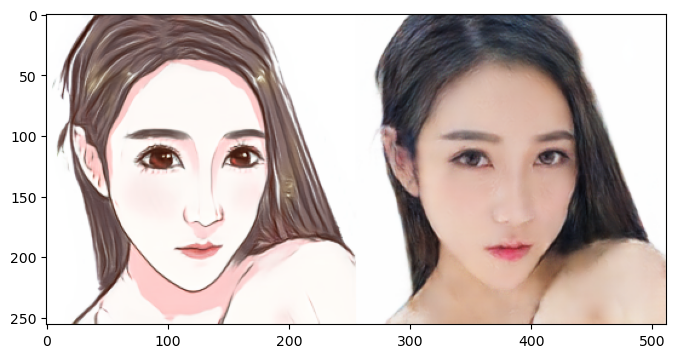

In [64]:
# 读取数据
test_names = os.listdir('../data/cartoon_A2B/test')
# img_name = np.random.choice(test_names)
img_name = '01481.png'
img_A2B = cv2.imread('../data/cartoon_A2B/test/'+img_name)
img_A = img_A2B[:, 256:]                                  # 卡通图（即输入）
img_B = img_A2B[:, :256]                                  # 真人图（即预测结果）

# img_A= cv2.imread('data/test4.png')
# img_A = img_A[:, 256:]

g_input = img_A.astype('float32') / 127.5 - 1             # 归一化
g_input = g_input[np.newaxis, ...].transpose(0, 3, 1, 2)  # NHWC -> NCHW
g_input = paddle.to_tensor(g_input)                       # numpy -> tensor

g_output = generator(g_input)
g_output = g_output.detach().numpy()                      # tensor -> numpy
g_output = g_output.transpose(0, 2, 3, 1)[0]              # NCHW -> NHWC
g_output = g_output * 127.5 + 127.5                       # 反归一化
g_output = g_output.astype(np.uint8)

img_show = np.hstack([img_A, g_output])[:,:,::-1]
plt.figure(figsize=(8, 8))
plt.imshow(img_show)
plt.show()